I originally analysed this dataset in a [blog post](https://jmmonteiro.github.io/in-the-beginning.html). But I thought I should leave it here as well.

Since I'm a beginner when it comes to Natural Language Processing (NLP), don't expect anything fancy. This post just describes some of my earlier experiments with [bag-of-words models](https://en.wikipedia.org/wiki/Bag-of-words_model) in a classification setting.

## Load packages

The first step is to load some of the packages necessary to run the analysis. The last line specifies the size of the plots that will be displayed.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14,10)

## Load data

Let's start by loading the data and checking how many samples we have.

In [7]:
bible = pd.read_csv('../input/bible_data_set.csv')
bible.shape

(31102, 5)

Next, we'll encode some extra information about the verses, namely, which testament and book they belong to. A quick google search tells us which books are contained in the KJV.

In [8]:
# Books in the Old Testament (OT) and New Testament (NT)
OT_books = ['Genesis', 'Exodus', 'Leviticus', 'Numbers', 'Deuteronomy', 'Joshua', 'Judges',
            'Ruth', '1 Samuel', '2 Samuel', '1 Kings', '2 Kings', '1 Chronicles', '2 Chronicles',
            'Ezra', 'Nehemiah', 'Esther', 'Job', 'Psalms', 'Proverbs', 'Ecclesiastes',
            'Song of Solomon', 'Isaiah', 'Jeremiah', 'Lamentations', 'Ezekiel', 'Daniel',
            'Hosea', 'Joel', 'Amos', 'Obadiah', 'Jonah', 'Micah', 'Nahum', 'Habakkuk',
            'Zephaniah', 'Haggai',    'Zechariah',    'Malachi']

NT_books = ['Matthew', 'Mark', 'Luke', 'John', 'Acts', 'Romans', '1 Corinthians',
            '2 Corinthians', 'Galatians', 'Ephesians', 'Philippians', 'Colossians',
            '1 Thessalonians', '2 Thessalonians', '1 Timothy', '2 Timothy', 'Titus', 'Philemon',
            'Hebrews', 'James', '1 Peter', '2 Peter', '1 John', '2 John', '3 John', 'Jude',
            'Revelation']

# New variables with the books and testaments as categories
books = pd.unique(bible.book)
book_codes = np.arange(1,len(books)+1)
book_codes = np.concatenate([books.reshape((-1,1)),book_codes.reshape((-1,1))], axis=1)

bible['book_code'] = np.nan
bible['testament'] = ''
bible['testament_code'] = np.nan
for i in range(0,bible.shape[0]):
    ind = bible.at[i,'book'] == book_codes[:,0]
    bible.at[i,'book_code'] = book_codes[ind,1]
    
    if bible.at[i,'book'] in OT_books:
        bible.at[i,'testament'] = 'Old Testament'
        bible.at[i,'testament_code'] = 0
    elif bible.at[i,'book'] in NT_books:
        bible.at[i,'testament'] = 'New Testament'
        bible.at[i,'testament_code'] = 1
    else:
        raise Exception('Book not found: ' + bible.at[i,'book'])

bible.book_code = bible.book_code.astype(int)
bible.book_code = pd.Categorical(bible.book_code)
bible.testament_code = bible.testament_code.astype(int)
bible.testament_code = pd.Categorical(bible.testament_code)
    
bible.head()

,citation,book,chapter,verse,text,book_code,testament,testament_code
0,Genesis 1:1,Genesis,1,1,In the beginning God created the heaven and th...,1,Old Testament,0
1,Genesis 1:2,Genesis,1,2,"And the earth was without form, and void; and ...",1,Old Testament,0
2,Genesis 1:3,Genesis,1,3,"And God said, Let there be light: and there wa...",1,Old Testament,0
3,Genesis 1:4,Genesis,1,4,"And God saw the light, that it was good: and G...",1,Old Testament,0
4,Genesis 1:5,Genesis,1,5,"And God called the light Day, and the darkness...",1,Old Testament,0


Before starting the analysis, I'll permute the data. This will break the order of the verses, preventing cases in which a structured chunk of the data (e.g. a chapter) is contained completely on the train set or on the test set. In other words, we want to have the chapters spread around the cross-validation folds.

In order to avoid problems with the cross-validation later on, I'll reset the index as well.

In [9]:
bible = bible.sample(frac=1, random_state=7).reset_index(drop=True)
bible.head()

,citation,book,chapter,verse,text,book_code,testament,testament_code
0,Psalms 12:2,Psalms,12,2,They speak vanity every one with his neighbour...,19,Old Testament,0
1,Ruth 2:7,Ruth,2,7,"And she said, I pray you, let me glean and gat...",8,Old Testament,0
2,Ezekiel 33:10,Ezekiel,33,10,"Therefore, O thou son of man, speak unto the h...",26,Old Testament,0
3,Psalms 139:1,Psalms,139,1,"O lord, thou hast searched me, and known me. \n",19,Old Testament,0
4,Judges 9:34,Judges,9,34,"And Abimelech rose up, and all the people that...",7,Old Testament,0


Looking good so far. Time for some machine learning.

## Old Testament vs. New Testament

The first task will be straightforward: classify which verses belong to the Old Testament (OT), and which verses belong to the New Testament (NT).

The first thing that one notices is that the OT is larger than the NT.

In [10]:
print('# verses in the OT: ' + str(np.sum(bible.testament_code==0)))
print('# verses in the NT: ' + str(np.sum(bible.testament_code==1)))

# verses in the OT: 23145
# verses in the NT: 7957


This means that we should probably do 2 things:

1. Use a classifier which takes the class imbalance into account. In this case, we will use a [Support Vector Machine (SVM)](https://en.wikipedia.org/wiki/Support_vector_machine) classifier with class weights to account for the class imbalance.

2. Use the *balanced accuracy* metric, instead of the overall accuracy. This simply corresponds to the average of the class accuracies.

The reason for the second point is easy to explain.

Imagine that you had a dataset comprised of 90% of samples in class A, and 10% in class B. If a machine learning model classified every sample as class A, the overall accuracy would be 90%. However, if you look at the balanced accuracy, it would be (100%+0%)/2 = 50%. The first metric might lead someone (at first glance) to think that the method was working well, whereas the second metric clearly indicates that the method does not generalise well.

We'll also use a StratifiedKFold cross-validation strategy, in order to preserve the ratio of the samples per class across the folds.

In [11]:
n_cv_folds = 10

X = bible.text
y = np.asarray(bible.testament_code)
from sklearn.metrics import accuracy_score

from sklearn.svm import LinearSVC
machine = LinearSVC(class_weight='balanced')

clf = machine

from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

# Use the stratified KFold strategy, in order to preserve the proportion of each class in all the folds
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=n_cv_folds)

acc = []
class_acc = []
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = vect.fit_transform(X_train)
    X_test = vect.transform(X_test)
    
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    
    # General accuracy
    acc.append(accuracy_score(y_test,y_pred))
    
    # Class accuracy
    ind = y_test == 0
    OT_acc = np.sum(y_test[ind] == y_pred[ind])
    OT_acc = OT_acc/np.sum(ind)
    
    ind = y_test == 1
    NT_acc = np.sum(y_test[ind] == y_pred[ind])
    NT_acc = NT_acc/np.sum(ind)
    
    class_acc.append([OT_acc, NT_acc])

Let's look at the accuracies.

In [12]:
class_acc = np.array(class_acc)
print('Accuracy: ' + str(np.mean(acc)))
print('Balanced Accuracy: ' + str(np.mean(class_acc[:])))

Accuracy: 0.917240437313
Balanced Accuracy: 0.903447664797


They are both quite similar, maybe due to the fact that SVM is already accounting for the class imbalance. If you omit the ``class_weight='balanced'`` option, the difference between the two will increase.

## Book classification

Since it was easy to classify the verses based on the testament, let's go one step further and see if we can predict the book from which they came from.

The procedure is very similar, but now the categories in the labels $\boldsymbol{y}$ are different, and the code to compute the class accuracies is more complex. We'll also introduce a new visualisation tool: the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

In [13]:
y = bible.book_code

from sklearn.metrics import confusion_matrix

from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(machine)

acc = []
class_acc = []
conf_mat = np.zeros((len(np.unique(y)),len(np.unique(y))))
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = vect.fit_transform(X_train)
    X_test = vect.transform(X_test)
    
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    
    # Class accuracy
    fold_class_acc = []
    for c in np.unique(y):
        ind = y_test == c
        dummy = np.sum(y_test[ind] == y_pred[ind])
        fold_class_acc.append(dummy/np.sum(ind))
    class_acc.append(fold_class_acc)    
    
    # Accuracy
    acc.append(accuracy_score(y_test,y_pred))
    
    # Confusion matrix
    conf_mat = conf_mat + confusion_matrix(y_test,y_pred)

Let's check the accuracies.

In [14]:
print('Accuracy: ' + str(np.mean(acc)))
print('Balanced Accuracy: ' + str(np.mean(class_acc[:])))

Accuracy: 0.463080519387
Balanced Accuracy: 0.306973023141


They're below 0.5 (50%), but don't forget that this is no longer a binary classification task. The KJV Bible has 66 books, so if the model was predicting the labels randomly, the accuracy would be around 1/66 (assuming equally sized classes), which is approximately 0.015 (1.5%).

Before taking a look at the confusion matrix. We should bear in mind that each book has a very different number of verses. In order to visualise the results better, a normalised version of the confusion matrix is created below, where the entries in each row (true labels) are divided by the number of samples in the corresponding class (i.e. row).

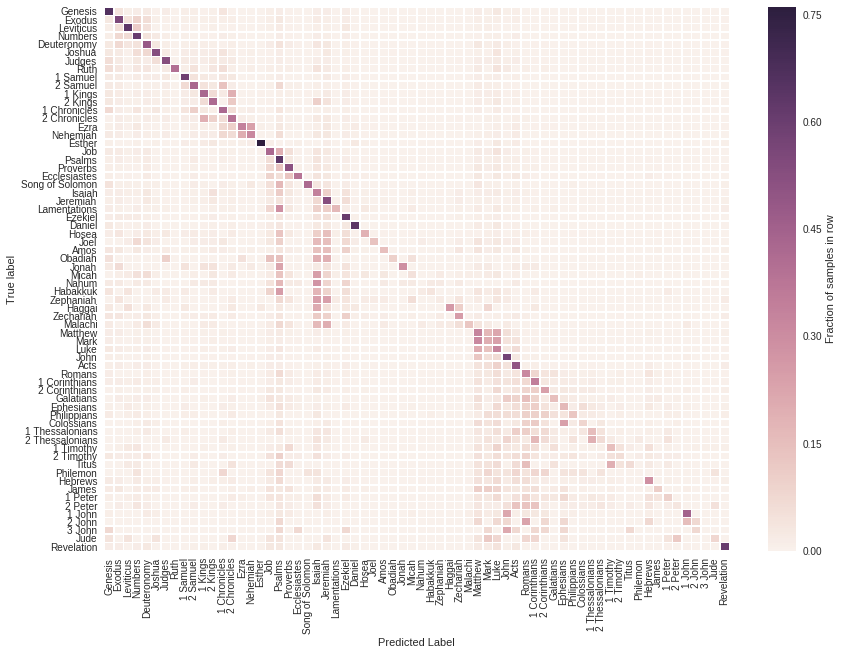

In [15]:
conf_mat_norm = np.transpose(np.transpose(conf_mat)/np.sum(conf_mat,axis=1))

ax = sns.heatmap(conf_mat_norm,
            xticklabels=books, yticklabels=books,
            linewidths=.5, cbar_kws={'label': 'Fraction of samples in row'})
ax.set(xlabel = 'Predicted Label', ylabel='True label')

plt.show()

As we can see, the accuracy of each class differs quite a bit, which means that some verses are easier to classify than others. Since we are using a bag-of-words model, this suggests that the classes with a higher accuracy contain verses with words which are quite different from the ones in the rest of the Bible. For example, the Genesis is easier to classify than the books at the end of the OT.

There seems to be a slightly higher similarity between books in the NT, specially between the first NT books, e.g. from Matthew to Corinthians. In fact, we can faintly see the "border" between the OT and the NT (between Malachi and Matthew). We can also sort the books by their class accuracies, which will give us an idea which books are more "unique", i.e. easier to classify.

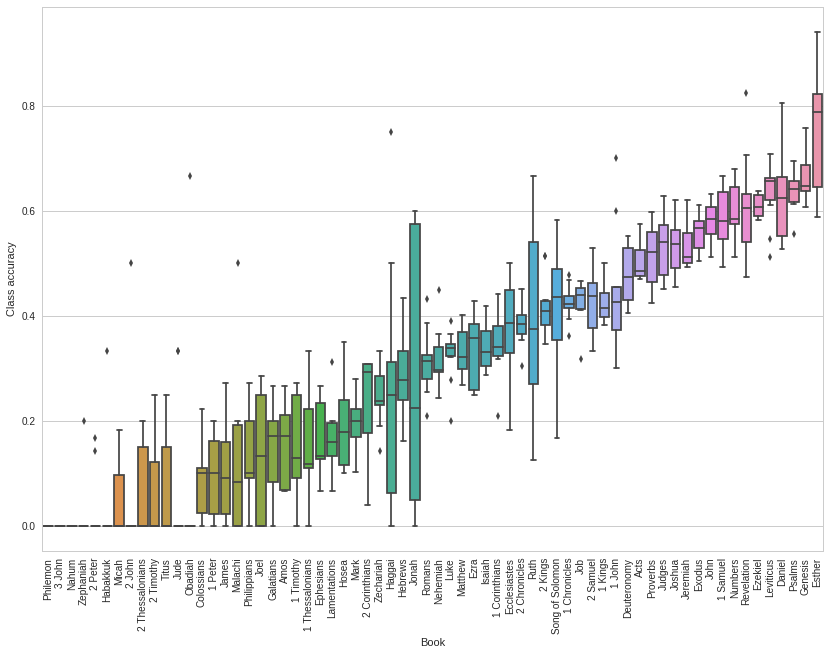

In [16]:
class_acc_plot = np.array(class_acc)
m = np.mean(class_acc,axis=0)

i = np.argsort(m)
class_acc_plot = class_acc_plot[:,i]
books_plot = books[i]

class_acc_plot = pd.DataFrame(class_acc_plot, columns=books_plot)

ax = sns.boxplot(data=class_acc_plot)
ax.set(xlabel = 'Book', ylabel='Class accuracy')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

plt.show()

# Conclusion

And that's it!

We could probably get a higher accuracy by using more [n-grams](https://en.wikipedia.org/wiki/Bag-of-words_model#N-gram_model) instead of just individual words (i.e. unigrams). However, this would also increase the number of features in the dataset. Alternatively, we could use more complex models, which take into account the context of the words. If I get around to implement them, I might revisit this problem.